In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Define  datasets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root = './data',train=True,download=True,transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256,shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root = './data',train=False,download=True,transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256,shuffle=False)

#Define a softmax operation
def softmax_operation(x):
    x_max,_ = torch.max(x,1,keepdim=True)
    e = torch.exp(x - x_max)
    u = torch.sum(e,1,keepdim=True)
    return e/u

#Define a model
class Net(nn.Module):
    def __init__(self,input_features,hidden_size,output_features):
        super().__init__() #nn.Moduleを継承
        self.linear1 = nn.Linear(input_features,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_features)
        nn.init.normal_(self.linear1.weight, mean=0,std=0.01) #重みを初期化
        nn.init.normal_(self.linear2.weight, mean=0,std=0.01) #重みを初期化
        self.layer_num = 2
        
    def forward(self,input):
        x = F.relu(self.linear1(input))
        x = self.linear2(x)
        output = softmax_operation(x)
        return output

model = Net(28*28,256,10)
#Define a cross-entropy loss
def cross_entropy_error(pred_y, y):
    return -1 * torch.mean(torch.sum( y * torch.log(pred_y),1))

#define a weight decay
def Weight_decay(Yourmodel):
    weight_decay_lambda = 0.001
    weight_decay = 0
    for i in range(1,Yourmodel.layer_num + 1):
        W = torch.sqrt(torch.sum(Yourmodel.state_dict()[f"linear{i}.weight"] ** 2))
        weight_decay += 0.5 * weight_decay_lambda * W**2
    return weight_decay



Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


C:\Users\Hiroto\AppData\Roaming\Python\Python37\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#Define a stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 
                         
epochs = 5
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_train_loss = None
best_train_acc = None
for epoch in range(epochs):  # loop over the dataset multiple times
    print("-"*30)
    print("epoch : {}".format(epoch))
    
    #train
    model.train()
    total_loss =0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [X, y]
        images, labels = data
        images = images.reshape(-1,28*28) #Flattening
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        with torch.set_grad_enabled(True):
            pred_y = model(images)
            _, predicted = torch.max(pred_y.data, 1)
            loss=cross_entropy_error(pred_y,torch.nn.functional.one_hot(labels, num_classes=10)) #labels -> ワンホットベクトル化)
            loss += Weight_decay(model)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        #acc
        correct += torch.sum(predicted == labels).item()  
        total += labels.size(0) 
    print(f"loss:{total_loss/i}")
    train_loss = total_loss/i
    train_losses.append(train_loss) #epochごとの平均lossを格納
    train_acc = float(correct / total)
    train_accuracies.append(train_acc) #epochごとの平均accを格納
    
    if best_train_loss is None  or best_train_loss > train_loss:
        best_train_loss = train_loss
    if best_train_acc  is None or train_acc > best_train_acc:
        best_train_acc =  train_acc

torch.save(model.state_dict(), './model.pth')
  
#test
model = Net(28*28,256,10)
model.load_state_dict(torch.load('./model.pth'))    
model.eval()  

total_loss =0
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(test_dataloader,0):
        images, labels = data
        images = images.reshape(-1,28*28)
        pred_y = model(images)
        _, predicted = torch.max(pred_y.data, 1)
        #loss
        loss=cross_entropy_error(pred_y,torch.nn.functional.one_hot(labels, num_classes=10)) #labels -> ワンホットベクトル化)
        total_loss += loss.item()
        #acc
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_loss = total_loss/i
    test_acc = float(correct / total)
       
        
# Plot result(loss)
plt.plot(range(1, epochs+1),train_losses,label="train")
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('./q4_l2_loss.png')
plt.close()

# Plot result(acc)
plt.plot(range(1, epochs+1),train_accuracies,label="train")
plt.title('Accuracies')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend()
plt.savefig('./q4_l2_acc.png')
plt.close()
print("-"*30)
print(f"best_train_loss: {best_train_loss}")
print(f"best_train_acc: {best_train_acc}")
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

------------------------------
epoch : 0
loss:2.181215858867026
------------------------------
epoch : 1
loss:1.551520569711669
------------------------------
epoch : 2
loss:1.1439731513333118
------------------------------
epoch : 3
loss:0.9609086630690811
------------------------------
epoch : 4
loss:0.8634793134326608
------------------------------
best_train_loss: 0.8634793134326608
best_train_acc: 0.6897666666666666
test_loss: 0.8425401005989466
test_acc: 0.6908


In [11]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.FashionMNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.FashionMNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    if dataset_name == 'example':
        train_dataset = example_dl(1000)
        train_dl = DataLoader(train_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    
    return train_dl, test_dl, valid_dl
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    data_num = 0
    correct_num = 0
    iter_num = 0

    for datas, targets in dl:
        datas, targets = datas.to(device), targets.to(device)
        data_num += len(targets)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

        if criterion != nn.MSELoss():
            prediction = torch.argmax(logits,dim=1)
            correct_num += (prediction == targets).sum().item()
    return losses/iter_num, correct_num/data_num

class MultPerceptronModel(torch.nn.Module):
    def __init__(self):
       super(MultPerceptronModel, self).__init__()
       self.fc1 = nn.Linear(784, 256, bias=True)
       self.fc2 = nn.Linear(256, 10, bias=True)
       self.relu = nn.ReLU()
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc1.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.softmax(y)
        return y
    
def train(model, train_dl, test_dl, epoch, device, criterion, optimizer, early_stop=5, valid_dl=None):

    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = [],[],[],[]
    best_train_loss, best_train_acc, best_test_loss, best_test_acc = None, None, None, None
    best_valid_loss = None
    count = 0
    
    for i in range(epoch):
        train_loss, train_acc = one_epoch(model, train_dl, device, criterion, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss
            best_train_acc = train_acc
        test_loss, test_acc = one_epoch(model, test_dl, device, criterion)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)

        if i==0 or best_test_loss >= test_loss:
            best_test_loss = test_loss
            best_test_acc = test_acc

        if i%5 == 0:
            print('EPOCH:{:}, Train: loss={:.3}, acc={:.3%} Test: loss={:.3}, acc={:.3%}'.format(i,train_loss, train_acc, test_loss, test_acc))
        
        if valid_dl:
            valid_loss, valid_acc = one_epoch(model, valid_dl, device, criterion)

            if i==0 or best_valid_loss >= valid_loss:
                best_valid_loss = valid_loss
                count = 0
            else:
                count += 1
                print('early stopping count = {:}'.format(count))
        
            if count >= early_stop:
                print('early stoping : final epoch = {:}'.format(i))
                break   
    
    print('Best train loss={:.3} Best test loss={:.3}'.format(best_train_loss, best_test_loss))
    print('Best train accuracy={:.3} Best test accuracy={:.3}'.format(best_train_acc, best_test_acc))

    return np.array(train_loss_list), np.array(test_loss_list), np.array(train_accuracy_list), np.array(test_accuracy_list)

0


C:\Users\Hiroto\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH:0, Train: loss=2.12, acc=49.307% Test: loss=1.89, acc=64.910%
EPOCH:5, Train: loss=1.7, acc=78.425% Test: loss=1.7, acc=77.970%
EPOCH:10, Train: loss=1.67, acc=80.178% Test: loss=1.68, acc=79.470%
EPOCH:15, Train: loss=1.66, acc=80.980% Test: loss=1.67, acc=80.150%
EPOCH:20, Train: loss=1.65, acc=81.452% Test: loss=1.66, acc=80.460%
EPOCH:25, Train: loss=1.65, acc=81.800% Test: loss=1.66, acc=80.670%
EPOCH:30, Train: loss=1.65, acc=82.083% Test: loss=1.66, acc=80.920%
EPOCH:35, Train: loss=1.64, acc=82.350% Test: loss=1.65, acc=81.260%
EPOCH:40, Train: loss=1.64, acc=82.585% Test: loss=1.66, acc=80.810%
EPOCH:45, Train: loss=1.64, acc=82.753% Test: loss=1.65, acc=81.230%
EPOCH:50, Train: loss=1.64, acc=82.892% Test: loss=1.65, acc=81.440%
EPOCH:55, Train: loss=1.64, acc=83.090% Test: loss=1.65, acc=81.730%
EPOCH:60, Train: loss=1.64, acc=83.123% Test: loss=1.65, acc=81.880%
EPOCH:65, Train: loss=1.63, acc=83.305% Test: loss=1.65, acc=81.840%
EPOCH:70, Train: loss=1.63, acc=83.378

C:\Users\Hiroto\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH:0, Train: loss=2.29, acc=42.045% Test: loss=2.29, acc=33.310%
EPOCH:5, Train: loss=2.3, acc=12.308% Test: loss=2.3, acc=11.990%
EPOCH:10, Train: loss=2.3, acc=15.100% Test: loss=2.3, acc=15.420%
EPOCH:15, Train: loss=2.3, acc=15.143% Test: loss=2.3, acc=14.650%
EPOCH:20, Train: loss=2.3, acc=15.195% Test: loss=2.3, acc=15.030%
EPOCH:25, Train: loss=2.3, acc=14.907% Test: loss=2.3, acc=14.770%
EPOCH:30, Train: loss=2.3, acc=15.013% Test: loss=2.3, acc=15.190%
EPOCH:35, Train: loss=2.3, acc=15.373% Test: loss=2.3, acc=15.210%
EPOCH:40, Train: loss=2.3, acc=14.532% Test: loss=2.3, acc=14.630%
EPOCH:45, Train: loss=2.3, acc=15.093% Test: loss=2.3, acc=15.440%
EPOCH:50, Train: loss=2.3, acc=15.233% Test: loss=2.3, acc=15.110%
EPOCH:55, Train: loss=2.3, acc=14.602% Test: loss=2.3, acc=15.490%
EPOCH:60, Train: loss=2.3, acc=14.623% Test: loss=2.3, acc=14.480%
EPOCH:65, Train: loss=2.3, acc=14.910% Test: loss=2.3, acc=15.940%
EPOCH:70, Train: loss=2.3, acc=14.860% Test: loss=2.3, acc=15.

C:\Users\Hiroto\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH:0, Train: loss=2.14, acc=42.557% Test: loss=1.95, acc=55.460%
EPOCH:5, Train: loss=1.79, acc=73.137% Test: loss=1.78, acc=73.730%
EPOCH:10, Train: loss=1.74, acc=77.782% Test: loss=1.75, acc=77.270%
EPOCH:15, Train: loss=1.74, acc=78.202% Test: loss=1.74, acc=77.580%
EPOCH:20, Train: loss=1.74, acc=78.410% Test: loss=1.74, acc=77.640%
EPOCH:25, Train: loss=1.74, acc=78.402% Test: loss=1.74, acc=77.640%
EPOCH:30, Train: loss=1.74, acc=78.418% Test: loss=1.74, acc=77.890%
EPOCH:35, Train: loss=1.74, acc=78.415% Test: loss=1.74, acc=77.700%
EPOCH:40, Train: loss=1.74, acc=78.435% Test: loss=1.74, acc=77.730%
EPOCH:45, Train: loss=1.74, acc=78.388% Test: loss=1.74, acc=77.690%
EPOCH:50, Train: loss=1.74, acc=78.382% Test: loss=1.74, acc=77.600%
EPOCH:55, Train: loss=1.74, acc=78.463% Test: loss=1.74, acc=77.660%
EPOCH:60, Train: loss=1.74, acc=78.432% Test: loss=1.74, acc=77.750%
EPOCH:65, Train: loss=1.74, acc=78.445% Test: loss=1.74, acc=77.700%
EPOCH:70, Train: loss=1.74, acc=78.4

C:\Users\Hiroto\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH:0, Train: loss=2.12, acc=47.830% Test: loss=1.9, acc=65.600%
EPOCH:5, Train: loss=1.7, acc=78.367% Test: loss=1.7, acc=77.880%
EPOCH:10, Train: loss=1.68, acc=80.045% Test: loss=1.68, acc=79.150%
EPOCH:15, Train: loss=1.67, acc=80.737% Test: loss=1.67, acc=79.880%
EPOCH:20, Train: loss=1.66, acc=81.138% Test: loss=1.67, acc=80.220%
EPOCH:25, Train: loss=1.66, acc=81.445% Test: loss=1.67, acc=80.440%
EPOCH:30, Train: loss=1.66, acc=81.607% Test: loss=1.67, acc=80.560%
EPOCH:35, Train: loss=1.66, acc=81.862% Test: loss=1.67, acc=80.690%
EPOCH:40, Train: loss=1.66, acc=81.975% Test: loss=1.67, acc=80.850%
EPOCH:45, Train: loss=1.66, acc=82.133% Test: loss=1.66, acc=81.010%
EPOCH:50, Train: loss=1.65, acc=82.170% Test: loss=1.66, acc=81.150%
EPOCH:55, Train: loss=1.65, acc=82.323% Test: loss=1.66, acc=81.070%
EPOCH:60, Train: loss=1.65, acc=82.412% Test: loss=1.66, acc=81.230%
EPOCH:65, Train: loss=1.65, acc=82.393% Test: loss=1.66, acc=81.250%
EPOCH:70, Train: loss=1.65, acc=82.500%

C:\Users\Hiroto\anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH:0, Train: loss=2.11, acc=49.603% Test: loss=1.91, acc=62.360%
EPOCH:5, Train: loss=1.76, acc=72.433% Test: loss=1.75, acc=72.340%
EPOCH:10, Train: loss=1.74, acc=73.623% Test: loss=1.74, acc=73.170%
EPOCH:15, Train: loss=1.73, acc=74.187% Test: loss=1.73, acc=73.610%
EPOCH:20, Train: loss=1.72, acc=74.555% Test: loss=1.72, acc=74.130%
EPOCH:25, Train: loss=1.72, acc=74.803% Test: loss=1.72, acc=74.200%
EPOCH:30, Train: loss=1.72, acc=75.007% Test: loss=1.72, acc=74.290%
EPOCH:35, Train: loss=1.71, acc=75.173% Test: loss=1.72, acc=74.500%
EPOCH:40, Train: loss=1.71, acc=75.353% Test: loss=1.72, acc=74.560%
EPOCH:45, Train: loss=1.71, acc=75.418% Test: loss=1.72, acc=74.750%
EPOCH:50, Train: loss=1.71, acc=75.545% Test: loss=1.72, acc=74.800%
EPOCH:55, Train: loss=1.71, acc=75.675% Test: loss=1.72, acc=74.850%
EPOCH:60, Train: loss=1.71, acc=75.775% Test: loss=1.71, acc=74.920%
EPOCH:65, Train: loss=1.71, acc=75.858% Test: loss=1.71, acc=74.910%
EPOCH:70, Train: loss=1.71, acc=75.8

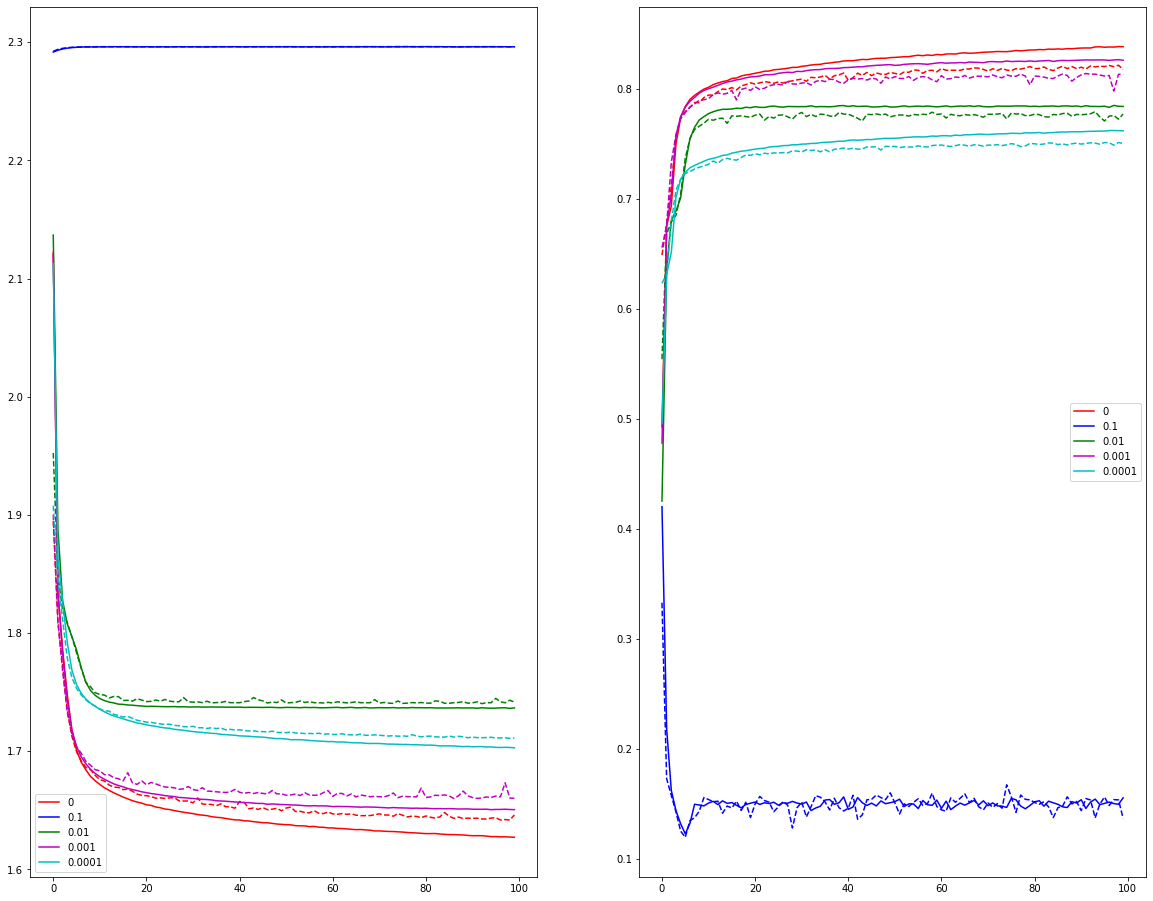

In [26]:
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform)

fig= plt.figure(figsize=(20.0, 16.0))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
colorlist = ['r', 'b', 'g', 'm', 'c']
_wd = [0, 0.1, 0.01, 0.001, 0.0001]

for idx, wd in enumerate(_wd):
    model = MultPerceptronModel()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=wd)
    print(wd)

    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

    ax1.plot(train_loss_list, colorlist[idx], label=wd)
    ax1.plot(test_loss_list, colorlist[idx],linestyle='dashed')
    ax2.plot(train_accuracy_list, colorlist[idx], label=wd)
    ax2.plot(test_accuracy_list, colorlist[idx],linestyle='dashed')

ax1.legend()
ax2.legend()
plt.savefig("Q4.png")

In [ ]:
model = MultPerceptronModel()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)